# EDA - unified notebook

**Run this entire file ONCE for each dataset of interest.**

Set the first line in the 'Configuration' section to the name of the dataset you wish to explore. One of:
* `prefrosh`
* `trait`
* `wellbeing_spring`

Then run the entire notebook and skim for the output text and plots, which are saved to the `plots` folder.

**Author: Everett Wetchler (`everett.wetchler@gmail.com`)**

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Configuration" data-toc-modified-id="Configuration-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Configuration</a></span></li><li><span><a href="#Setup-and-load-data" data-toc-modified-id="Setup-and-load-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Setup and load data</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Constants" data-toc-modified-id="Constants-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Constants</a></span></li><li><span><a href="#Helper-functions" data-toc-modified-id="Helper-functions-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Helper functions</a></span></li><li><span><a href="#Load-data" data-toc-modified-id="Load-data-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Load data</a></span></li></ul></li><li><span><a href="#Correlations-amongst-scales" data-toc-modified-id="Correlations-amongst-scales-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Correlations amongst scales</a></span><ul class="toc-item"><li><span><a href="#Same-plot,-but-controlling-for-spurious-values-and-multiple-testing." data-toc-modified-id="Same-plot,-but-controlling-for-spurious-values-and-multiple-testing.-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Same plot, but controlling for spurious values and multiple testing.</a></span></li></ul></li><li><span><a href="#Univariate-summary-statistics" data-toc-modified-id="Univariate-summary-statistics-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Univariate summary statistics</a></span></li><li><span><a href="#PCA" data-toc-modified-id="PCA-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>PCA</a></span></li></ul></div>

<div style="background-color: rgba(164,0,0,1);height: 20px"></div><!-- Thick deep-red bar -->

## Configuration

In [1]:
DATA_INPUT_DIR = 'data/postprocessed/'
RESULTS_DIR = 'data/results/'
WRITE_RESULTS = True

# DATASET = 'prefrosh'
DATASET = 'trait'
# DATASET = 'wellbeing_spring'

print(f"** Running EDA for {DATASET} **")

<div style="background-color: #A33;height: 20px"></div> <!-- Red bar -->

## Setup and load data

### Imports

In [2]:
####################################################
# Boilerplate import/setup code for general analysis
# everett.wetchler@gmail.com
####################################################

# Plot directly in notebook
# NOTE: break this command into it's own cell, and run
# it BEFORE everything below it. Unfortunately that's
# the only way to get the plot settings to stick.
%matplotlib inline

Everett Wetchler 2019-12-03 11:53:33 PST 

CPython 3.6.5
IPython 7.8.0

numpy 1.17.3
pandas 0.25.1
matplotlib 3.1.0
seaborn 0.9.0
watermark 2.0.1


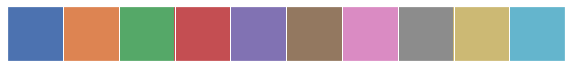

In [3]:
import datetime as dt
import os
import random
import simplejson as json

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
sns.set()

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 500)

# Customize default chart graphics
mpl.rcParams.update({
  'font.size': 14,
  'axes.titlesize': 'x-large',
  'axes.labelsize': 'large',
  'xtick.labelsize': 'medium',
  'ytick.labelsize': 'medium',
  'legend.fancybox': True,
  'legend.fontsize': 'medium',
  'legend.frameon': True,
  'legend.framealpha': 0.7,
  'figure.figsize': ['9', '6'],
})

# It's useful to have some named colors handy
(SNS_BLUE, SNS_ORANGE, SNS_GREEN,
 SNS_RED, SNS_PURPLE, SNS_BROWN,
 SNS_PINK, SNS_GRAY, SNS_YELLOW,
 SNS_CYAN) = sns.color_palette()
sns.palplot(sns.color_palette())

# Watermark extension to print version/system information
# Flags:
# -a [author] --v (python/ipython versions) -d (date)
# -t (time) -z (timezone) -r (repo)
# -g (git hash) -w (watermark version)
# -p [packages] (package info)
%load_ext watermark
%watermark -a 'Everett Wetchler' -v -d -t -z -w -p numpy,pandas,matplotlib,seaborn

%load_ext autoreload
%autoreload 2

####################################################
# END Boilerplate
####################################################

In [4]:
# Additional libs needed
import matplotlib.ticker as mtick
import scipy
import scipy.cluster.hierarchy as sch
from sklearn import decomposition
from sklearn import preprocessing

### Constants

In [5]:
PLOT_FILE_FMT = os.path.join(RESULTS_DIR, '%s_%%s.png' % DATASET)
DATASET_DISPLAYNAME = DATASET.lower().capitalize().replace('_', '-')

PREFROSH = 'prefrosh'
TRAIT = 'trait'
WELLBEING_SPRING = 'wellbeing_spring'

SCALE_COLUMNS = {
    PREFROSH: [
        'Extraversion', 'BAS', 'NTB', 'EC', 'PD', 'PT', 'Prosociality',
        'Loneliness', 'PSS', 'Subj_Happiness', 'SWL', 'MalleableEmpathy'],
    TRAIT: ['Extraversion', 'Agreeableness', 'Openness',
       'Conscientiousness', 'NPI', 'Positive_empathy', 'Pos_efficacy',
       'Neg_efficacy', 'Pos_tendency', 'Neg_Tendency', 'CESD', 'STAI_Anxiety',
       'Need_Belong', 'Prosociality', 'Loneliness', 'PSS', 'SubjHappiness',
       'SWLS', 'Emp_theory', 'RS_1', 'RS_2', 'Self_Esteem', 'Self_monitor',
       'Distress_Disclosure', 'Guidance', 'Warmth', 'Integration',
       'Attachment', 'Nurturance', 'Reliable', 'Anticipated_Risks',
       'Anticipated_Benefits', 'beq.nex', 'beq.pex', 'beq.str', 'PI', 'SI',
       'CI', 'BFNE', 'BAS_drive', 'BAS_Fun_seeking',
       'BAS_Fun_Reward_responsiveness', 'Suppression', 'Cogntive_Reappraisal',
       'Extensic_improve', 'Extensic_worse', 'Intrinsic_imrpove',
       'Intrinsic_worse', 'Empathic_Concern', 'Perspective_Taking',
       'Personal_Distress'],
    WELLBEING_SPRING: [
        'Wellbeing_self_17', 'Lonely', 'Stressed', 'Satisfied', 'Rumination',
        'Wellbeing_self_18', 'Social_Anxiety', 'Wellbeing_self_22', 'Anxiety_1',
        'Anxiety_2', 'Wellbeing_self_19', 'Depression', 'Anhedonia',
        'Wellbeing_self_21', 'Belonging'],
}

SCALE_COLUMNS = SCALE_COLUMNS[DATASET]

print(f"{len(SCALE_COLUMNS)} scales found")

51 scales found


### Helper functions

In [6]:
def upper_triangle(X):
    '''Given a matrix (2d array), keep only values above the diagonal.'''
    Y = X.copy()
    for i in range(len(X)):
        for j in range(i, len(X)):
            Y.iloc[j, i] = None
    return Y

def clustered_corr(df):
    '''Generate a correlation matrix, grouping similar rows/cols visually.
    
    Method/code from https://github.com/TheLoneNut/
           CorrelationMatrixClustering/blob/master/
           CorrelationMatrixClustering.ipynb
    '''
    X = df.corr().abs()
    for i in range(len(X)):
        X.iloc[i, i] = 0
    X = X.values
    d = sch.distance.pdist(X)   # vector of (N choose 2) pairwise distances
    L = sch.linkage(d, method='complete')
    ind = sch.fcluster(L, 0.5*d.max(), 'distance')
    columns = [df.columns.tolist()[i] for i in list((np.argsort(ind)))]
    corr = df[columns].corr()
    return upper_triangle(corr)

In [7]:
def percentify_axis(x_or_y_axis, decimals=None):
    '''Convert axis tick labels from floats to percentages.'''
    x_or_y_axis.set_major_formatter(
        mtick.PercentFormatter(xmax=1, decimals=decimals))

def percentify_x(ax, decimals=None):
    '''Convert x-axis tick labels from floats to percentages.'''
    percentify_axis(ax.xaxis)

def percentify_y(ax, decimals=None):
    '''Convert y-axis tick labels from floats to percentages.'''
    percentify_axis(ax.yaxis)

In [8]:
def saveplot(fig, name):
    if WRITE_RESULTS:
        fig.savefig(PLOT_FILE_FMT % name)
    else:
        print('To have this notebook save plots to a file, '
              'set WRITE_RESULTS=True in the configuration.')

In [9]:
if WRITE_RESULTS:
    if not os.path.exists(RESULTS_DIR):
        os.mkdir(RESULTS_DIR)
    print("Writing results (plots, etc) to:", RESULTS_DIR)

Writing results (plots, etc) to: data/results/


### Load data

In [10]:
df = pd.read_csv(os.path.join(DATA_INPUT_DIR, DATASET + '.csv'))
df.head()

,PID,NID,DID,Extraversion,Agreeableness,Openness,Conscientiousness,NPI,Positive_empathy,Pos_efficacy,Neg_efficacy,Pos_tendency,Neg_Tendency,CESD,STAI_Anxiety,Need_Belong,Prosociality,Loneliness,PSS,SubjHappiness,SWLS,Emp_theory,RS_1,RS_2,Self_Esteem,Self_monitor,Distress_Disclosure,Guidance,Warmth,Integration,Attachment,Nurturance,Reliable,Anticipated_Risks,Anticipated_Benefits,beq.nex,beq.pex,beq.str,PI,SI,CI,BFNE,BAS_drive,BAS_Fun_seeking,BAS_Fun_Reward_responsiveness,Suppression,Cogntive_Reappraisal,Extensic_improve,Extensic_worse,Intrinsic_imrpove,Intrinsic_worse,Empathic_Concern,Perspective_Taking,Personal_Distress,questions_complete,questions_incomplete,scores_complete,scores_incomplete,time_seconds,time_minutes,date
0,01DGcnKSFh,10,10,5.5,7.0,6.0,5.0,4.400000,5.714286,7.00,7.50,7.50,7.25,3.2,3.631579,4.3,3.666667,0.875,1.25,7.50,6.6,2.666667,5.125,4.625,1.5,17,3.500000,4.00,4.00,3.75,3.25,3.0,3.75,4.25,5.50,5.000000,7.75,5.666667,6.000000,4.50,4.750,3.000000,4.75,4.25,5.0,2.75,7.000000,6.000000,2.0,5.333333,2.75,3.666667,2.714286,1.000000,395,9,51,0,412913,6881,2018-10-06 11:43:51
1,060uyicrNj,9,9,3.5,4.5,3.5,6.0,4.333333,4.714286,6.50,6.25,5.75,6.75,3.6,2.842105,4.3,2.666667,1.875,1.75,5.25,6.2,3.833333,5.375,5.750,2.2,10,3.357143,2.50,3.25,3.25,2.50,3.0,3.25,4.25,4.00,3.166667,5.75,5.666667,4.500000,5.00,4.625,4.571429,4.50,4.00,3.6,5.00,6.333333,4.833333,5.0,4.500000,4.75,2.000000,2.428571,2.142857,395,9,51,0,6291,104,2018-10-05 18:44:03
2,08JYVDNSVE,2,2,7.0,8.0,6.0,6.5,3.666667,6.000000,7.25,7.75,6.00,4.50,3.2,3.578947,5.0,2.666667,2.000,2.75,4.75,5.4,4.000000,5.375,5.250,2.9,10,3.785714,2.75,3.50,3.50,3.00,3.0,3.25,6.00,4.50,7.166667,8.00,7.000000,5.500000,4.75,4.375,6.000000,3.50,4.50,5.0,4.50,6.833333,4.166667,2.0,3.500000,6.00,3.500000,3.285714,2.428571,395,9,51,0,9974,166,2018-10-05 16:39:09
3,09sqjhTBY5,4,4,2.5,4.5,6.0,5.5,3.066667,4.142857,5.00,6.75,4.25,3.00,2.4,2.473684,3.8,3.333333,1.125,0.75,4.75,4.8,3.500000,6.750,4.750,2.3,13,2.357143,3.25,3.25,3.25,3.25,2.0,3.25,5.00,4.25,3.500000,6.00,6.333333,5.000000,4.25,3.750,4.142857,3.50,4.00,4.2,4.25,4.666667,3.166667,2.0,3.166667,2.50,2.833333,2.142857,2.571429,396,8,51,0,2777,46,2018-10-07 17:30:58
4,0fgViPMzN8,7,7,6.0,6.5,7.0,5.5,3.600000,4.428571,6.75,6.00,4.50,3.25,2.8,2.526316,4.2,3.333333,0.500,1.25,6.25,6.0,0.500000,5.375,5.375,1.2,19,3.142857,4.00,4.00,3.50,3.75,3.0,4.00,5.00,4.00,4.333333,5.50,6.666667,5.833333,4.00,4.125,4.285714,3.50,2.25,4.0,6.25,6.166667,5.166667,2.0,3.166667,3.50,3.166667,2.428571,1.428571,395,9,51,0,2337,38,2018-10-07 17:35:17


<div style="background-color: #A33;height: 20px"></div> <!-- Red bar -->

## Correlations amongst scales

In [11]:
scores = df[SCALE_COLUMNS]
scores.head()

,Extraversion,Agreeableness,Openness,Conscientiousness,NPI,Positive_empathy,Pos_efficacy,Neg_efficacy,Pos_tendency,Neg_Tendency,CESD,STAI_Anxiety,Need_Belong,Prosociality,Loneliness,PSS,SubjHappiness,SWLS,Emp_theory,RS_1,RS_2,Self_Esteem,Self_monitor,Distress_Disclosure,Guidance,Warmth,Integration,Attachment,Nurturance,Reliable,Anticipated_Risks,Anticipated_Benefits,beq.nex,beq.pex,beq.str,PI,SI,CI,BFNE,BAS_drive,BAS_Fun_seeking,BAS_Fun_Reward_responsiveness,Suppression,Cogntive_Reappraisal,Extensic_improve,Extensic_worse,Intrinsic_imrpove,Intrinsic_worse,Empathic_Concern,Perspective_Taking,Personal_Distress
0,5.5,7.0,6.0,5.0,4.400000,5.714286,7.00,7.50,7.50,7.25,3.2,3.631579,4.3,3.666667,0.875,1.25,7.50,6.6,2.666667,5.125,4.625,1.5,17,3.500000,4.00,4.00,3.75,3.25,3.0,3.75,4.25,5.50,5.000000,7.75,5.666667,6.000000,4.50,4.750,3.000000,4.75,4.25,5.0,2.75,7.000000,6.000000,2.0,5.333333,2.75,3.666667,2.714286,1.000000
1,3.5,4.5,3.5,6.0,4.333333,4.714286,6.50,6.25,5.75,6.75,3.6,2.842105,4.3,2.666667,1.875,1.75,5.25,6.2,3.833333,5.375,5.750,2.2,10,3.357143,2.50,3.25,3.25,2.50,3.0,3.25,4.25,4.00,3.166667,5.75,5.666667,4.500000,5.00,4.625,4.571429,4.50,4.00,3.6,5.00,6.333333,4.833333,5.0,4.500000,4.75,2.000000,2.428571,2.142857
2,7.0,8.0,6.0,6.5,3.666667,6.000000,7.25,7.75,6.00,4.50,3.2,3.578947,5.0,2.666667,2.000,2.75,4.75,5.4,4.000000,5.375,5.250,2.9,10,3.785714,2.75,3.50,3.50,3.00,3.0,3.25,6.00,4.50,7.166667,8.00,7.000000,5.500000,4.75,4.375,6.000000,3.50,4.50,5.0,4.50,6.833333,4.166667,2.0,3.500000,6.00,3.500000,3.285714,2.428571
3,2.5,4.5,6.0,5.5,3.066667,4.142857,5.00,6.75,4.25,3.00,2.4,2.473684,3.8,3.333333,1.125,0.75,4.75,4.8,3.500000,6.750,4.750,2.3,13,2.357143,3.25,3.25,3.25,3.25,2.0,3.25,5.00,4.25,3.500000,6.00,6.333333,5.000000,4.25,3.750,4.142857,3.50,4.00,4.2,4.25,4.666667,3.166667,2.0,3.166667,2.50,2.833333,2.142857,2.571429
4,6.0,6.5,7.0,5.5,3.600000,4.428571,6.75,6.00,4.50,3.25,2.8,2.526316,4.2,3.333333,0.500,1.25,6.25,6.0,0.500000,5.375,5.375,1.2,19,3.142857,4.00,4.00,3.50,3.75,3.0,4.00,5.00,4.00,4.333333,5.50,6.666667,5.833333,4.00,4.125,4.285714,3.50,2.25,4.0,6.25,6.166667,5.166667,2.0,3.166667,3.50,3.166667,2.428571,1.428571


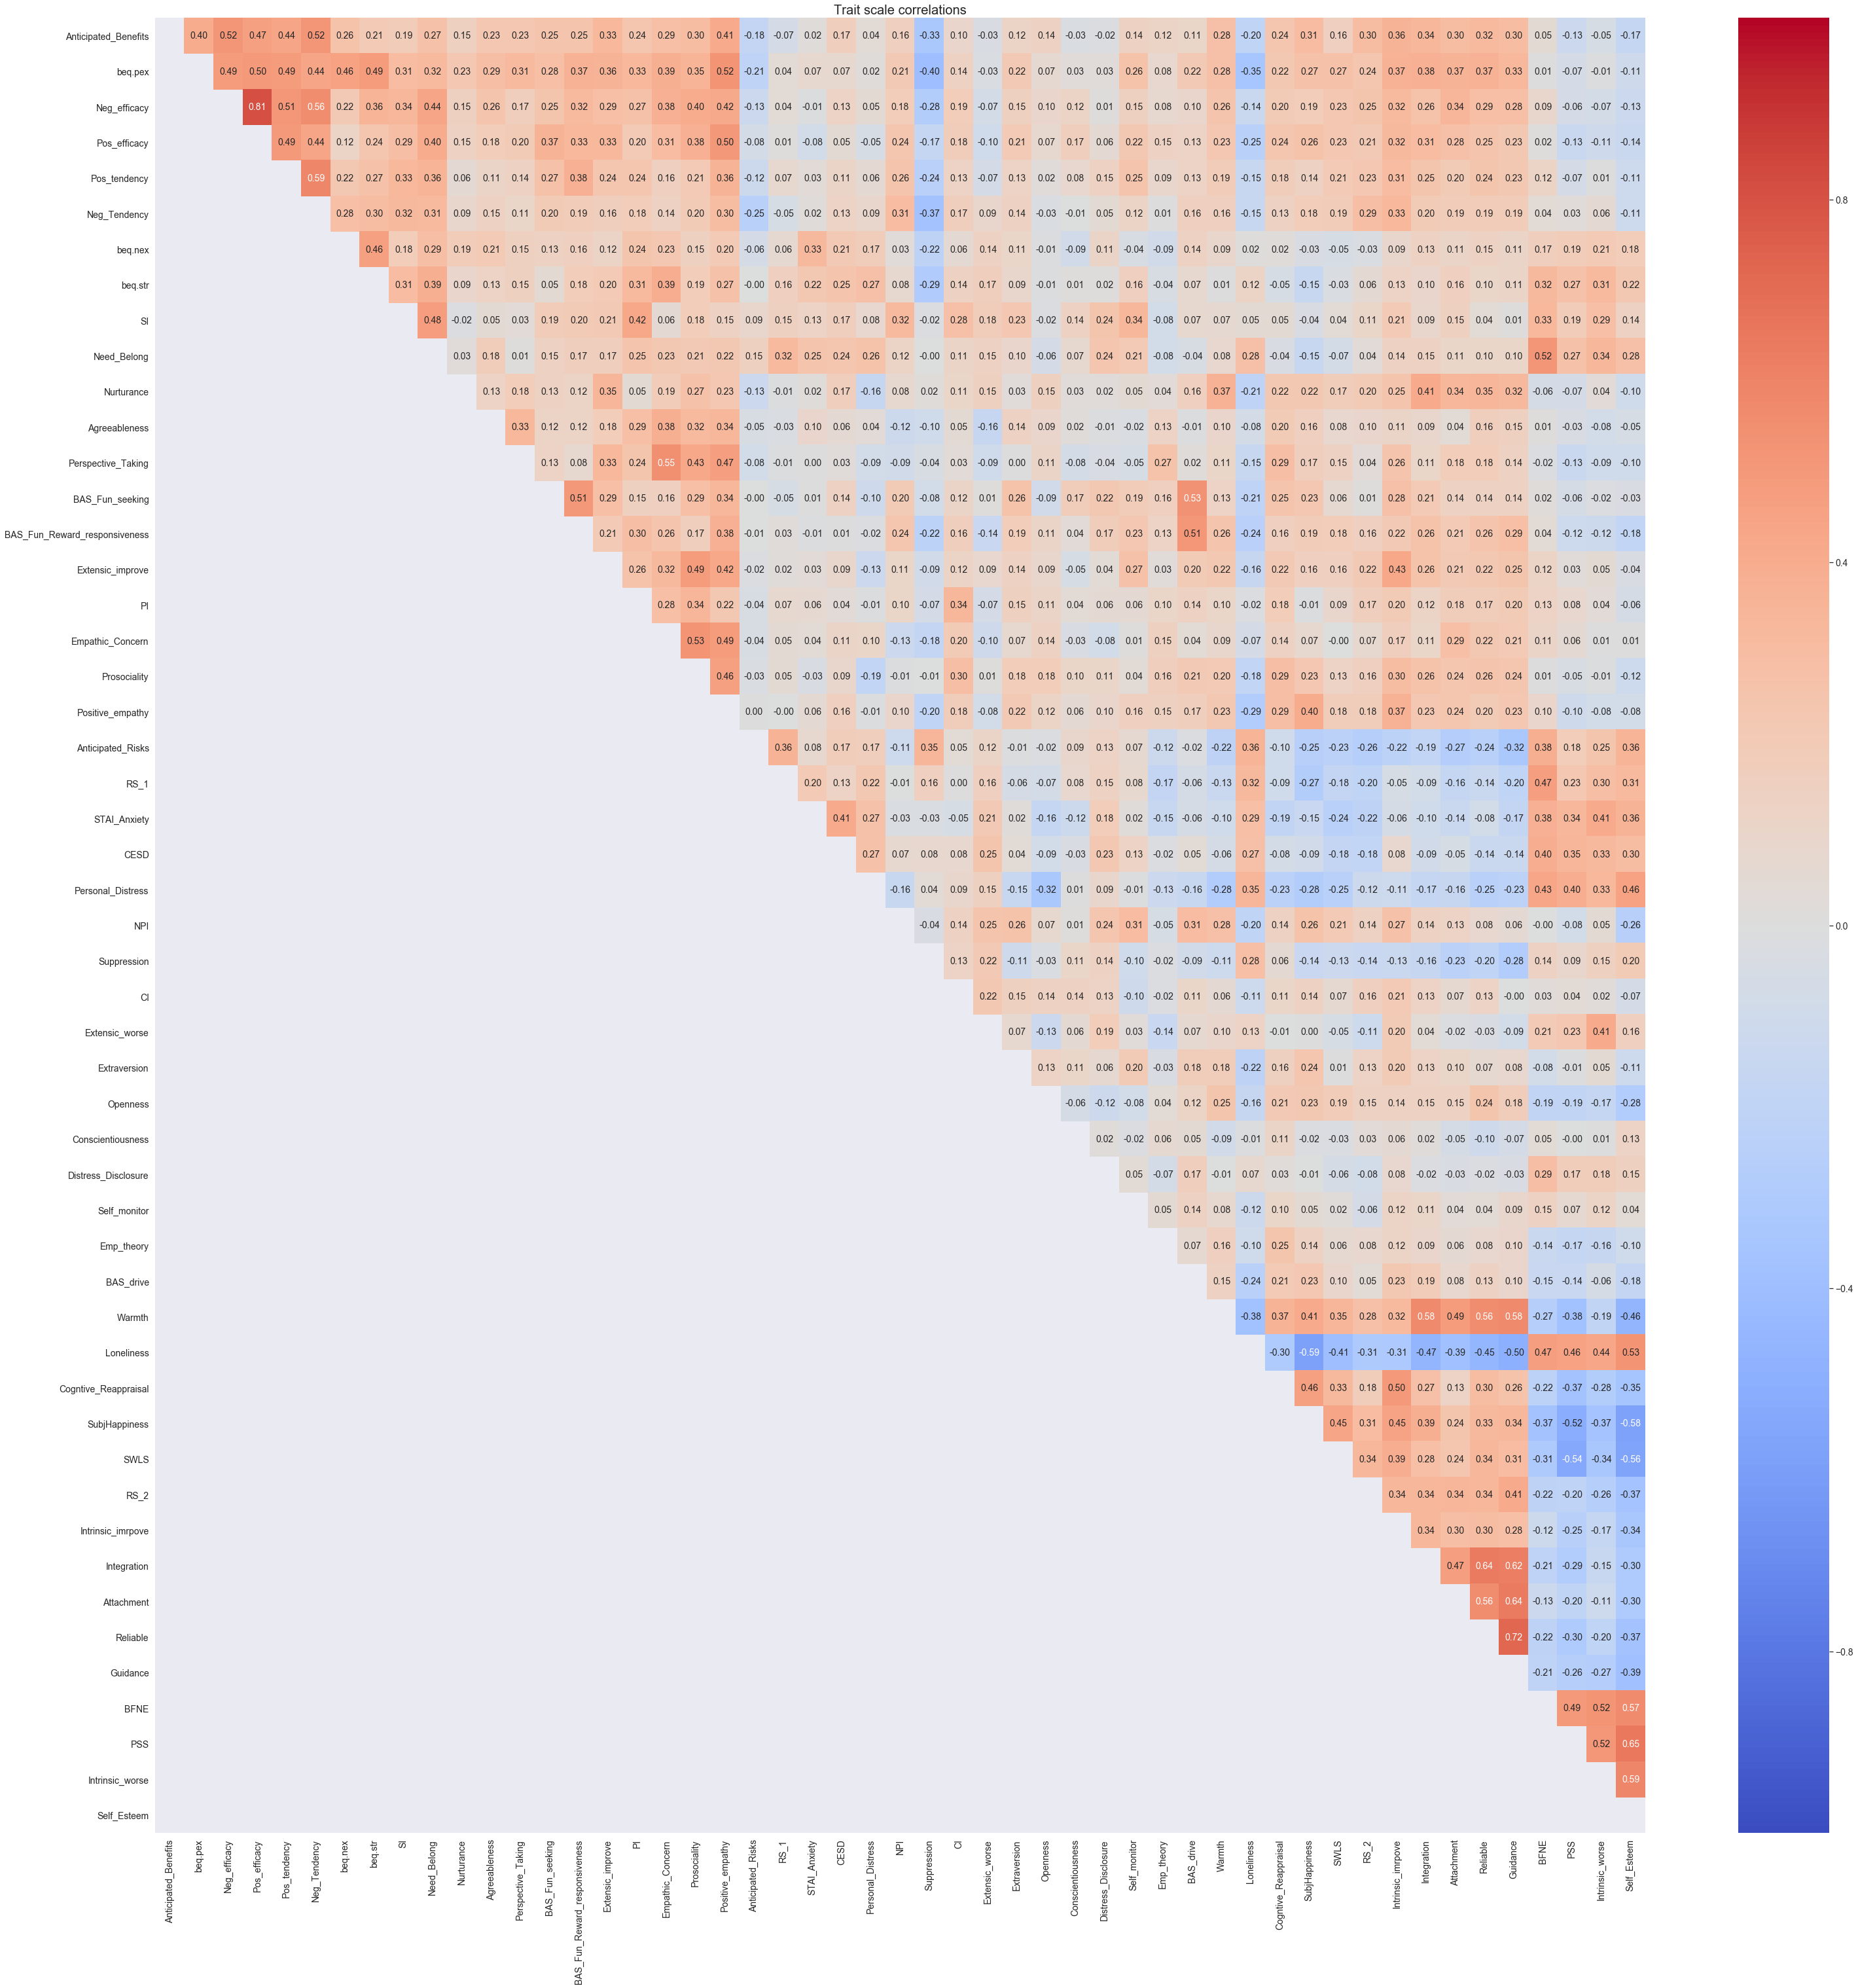

In [12]:
corr = clustered_corr(scores)

fig, ax = plt.subplots(1)
fig.set_size_inches(len(corr), len(corr))
sns.heatmap(corr, annot=True, ax=ax, fmt='.2f', vmin=-1, center=0, vmax=1, cmap="coolwarm")
ax.set_title(f"{DATASET_DISPLAYNAME} scale correlations")
saveplot(fig, 'correlations_all')

<div style="background-color: rgba(194,0,0,.6);height: 15px"></div><!-- Medium red bar -->

### Same plot, but controlling for spurious values and multiple testing.

1. Copy the dataframe
1. For each scale, independently, randomly shuffle the Ps responses (so there is no true correlation amongst scales and all correlations are, by design, spurious).
1. Record all correlations, which are spurious by design.
1. In our original correlation matrix, drop all correlations that are lower (in absolute value) than the 95% highest spurious correlation across all permutation trials.
1. Re-plot the correlation matrix

In [13]:
all_spurious = []
trials = []
for i in range(1000):
    if i % 100 == 0:
        print(i, end=' ')
    shuffle_df = scores.copy()
    for c in shuffle_df.columns:
        shuffle_df[c] = shuffle_df[c].sample(frac=1, replace=False).values
    corr = shuffle_df.corr().abs()
    values = []
    for i, col in enumerate(corr.columns):
        values.extend(list(corr[col].iloc[i+1:]))
    trials.append(values)
    all_spurious.extend(values)

0 100 200 300 400 500 600 700 800 900 

Text(0.5, 1.0, 'Shuffle test - probability of various spurious correlations')

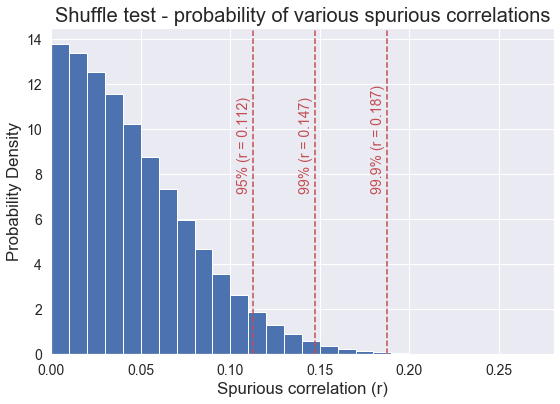

In [14]:
fig, ax = plt.subplots(1)
all_spurious = pd.Series(all_spurious)
all_spurious.apply(np.abs).hist(bins=np.arange(0, 1.0, .01), ax=ax, density=True)
max_x = max(all_spurious)
ax.set_xlim(0, max_x)
for pct in [95, 99, 99.9]:
    value = np.percentile(all_spurious, pct)
    ax.axvline(value, ymax=ax.get_ylim()[1], color=SNS_RED, linestyle='--')
    pct_str = '%.1f%%' % pct if pct > 99 else '%.0f%%' % pct
    ax.text(value - .001, ax.get_ylim()[1] / 2, '%s (r = %.3f)' % (pct_str, value),
            rotation=90, color=SNS_RED, horizontalalignment='right')

ax.set_xlabel("Spurious correlation (r)")
ax.set_ylabel('Probability Density')
ax.set_title(f"Shuffle test - probability of various spurious correlations")

In [15]:
top2 = [sorted(x)[-2:] for x in trials]
frame = pd.DataFrame(top2, columns=['second', 'first'])

/Users/everettwetchler/.pyenv/versions/3.6.5/lib/python3.6/site-packages/seaborn/axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


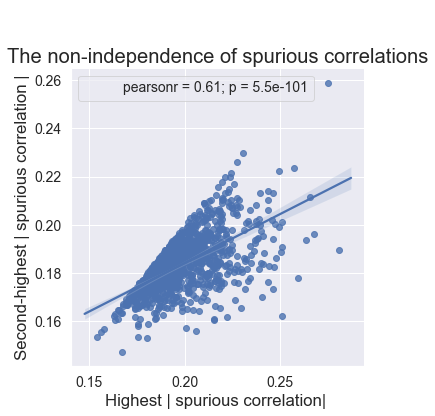

In [16]:
jg = sns.JointGrid('first', 'second', data=frame)
jg.plot_joint(sns.regplot)
jg.annotate(stats.pearsonr)
jg.ax_marg_x.set_axis_off()
jg.ax_marg_y.set_axis_off()
jg.ax_joint.set_title('The non-independence of spurious correlations')
jg.ax_joint.set_xlabel("Highest | spurious correlation| ")
jg.ax_joint.set_ylabel("Second-highest | spurious correlation |");

Graying out correlations whose abs value is < 0.112 (higher than 95% of spurious correlations)


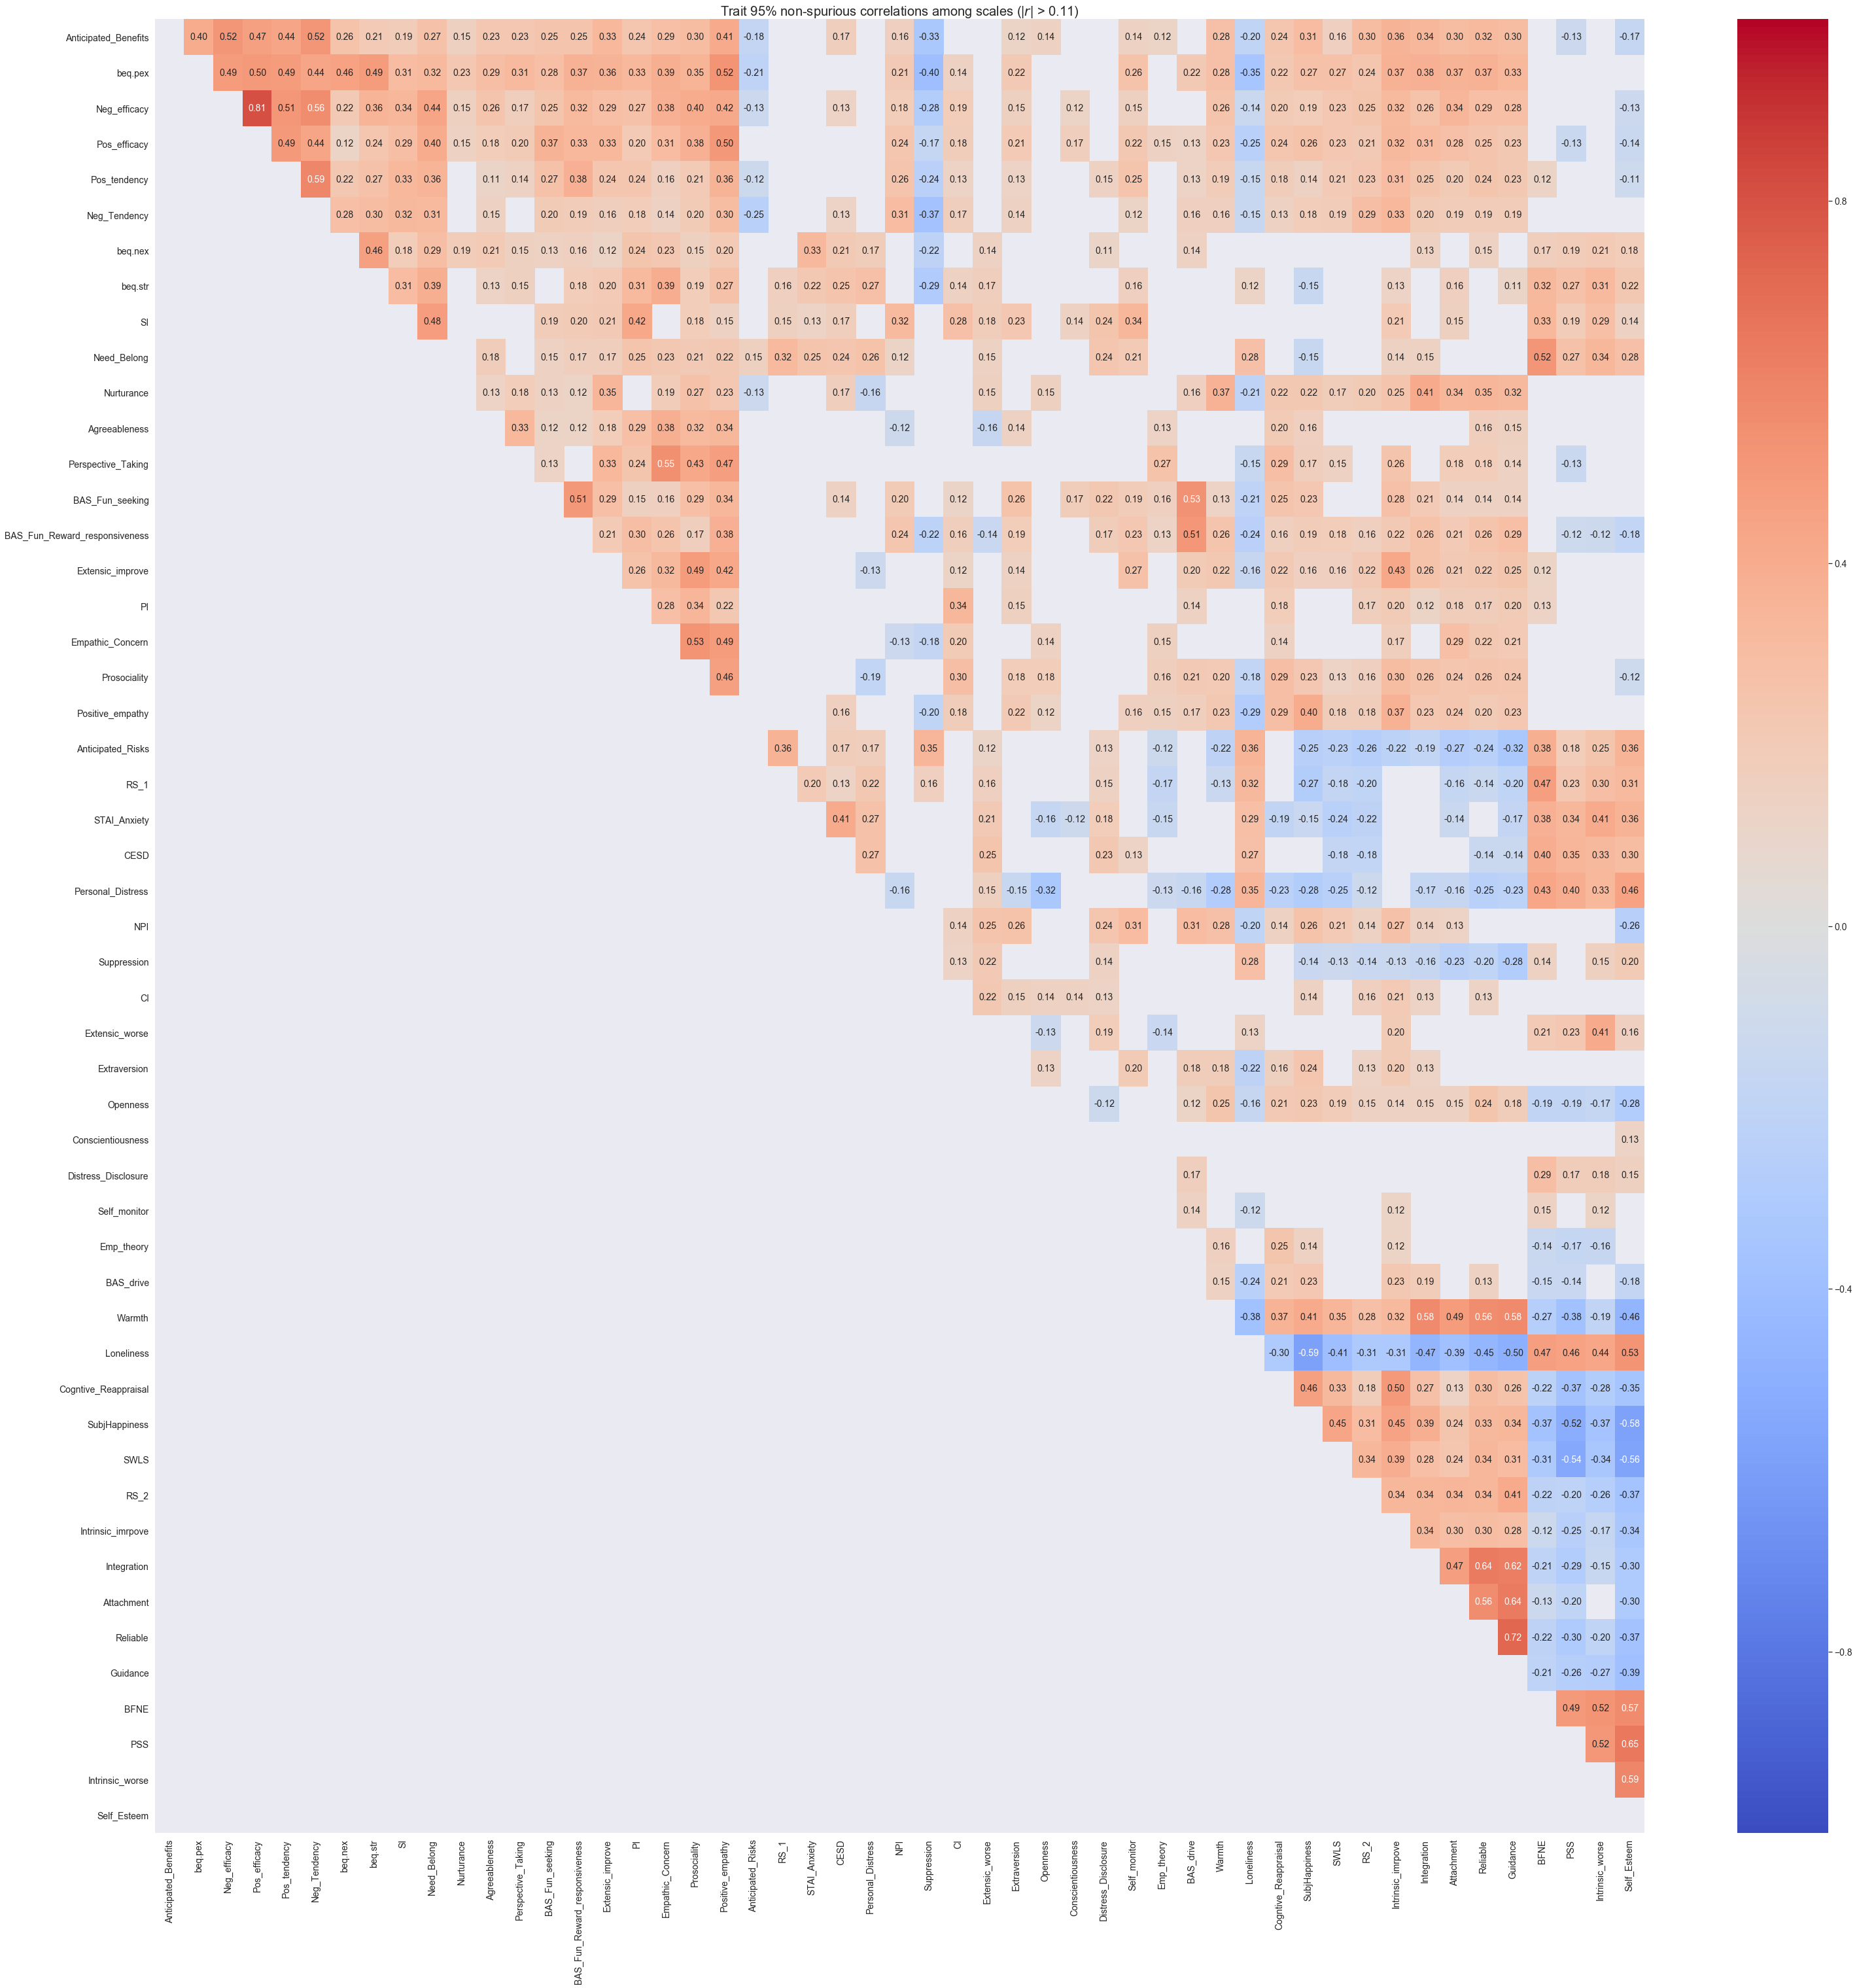

In [17]:
THRESHOLD_PCT = 95

THRESHOLD = np.percentile(all_spurious, THRESHOLD_PCT)
print(f"Graying out correlations whose abs value is < {THRESHOLD:.3f} (higher than {THRESHOLD_PCT}% of spurious correlations)")
corr = clustered_corr(scores)
for i, col in enumerate(corr):
    corr[col] = corr[col].apply(lambda r: None if abs(r) < THRESHOLD else r)

fig, ax = plt.subplots(1)
fig.set_size_inches(len(corr), len(corr))
sns.heatmap(corr, annot=True, ax=ax, fmt='.2f', vmin=-1, center=0, vmax=1, cmap="coolwarm")
ax.set_title(f"{DATASET_DISPLAYNAME} {THRESHOLD_PCT}% non-spurious correlations among scales (|$r$| > {THRESHOLD:.2f})")
saveplot(fig, 'correlations_significant')

<div style="background-color: #A33;height: 20px"></div> <!-- Red bar -->

## Univariate summary statistics

Creating grid of plots, 7 x 8


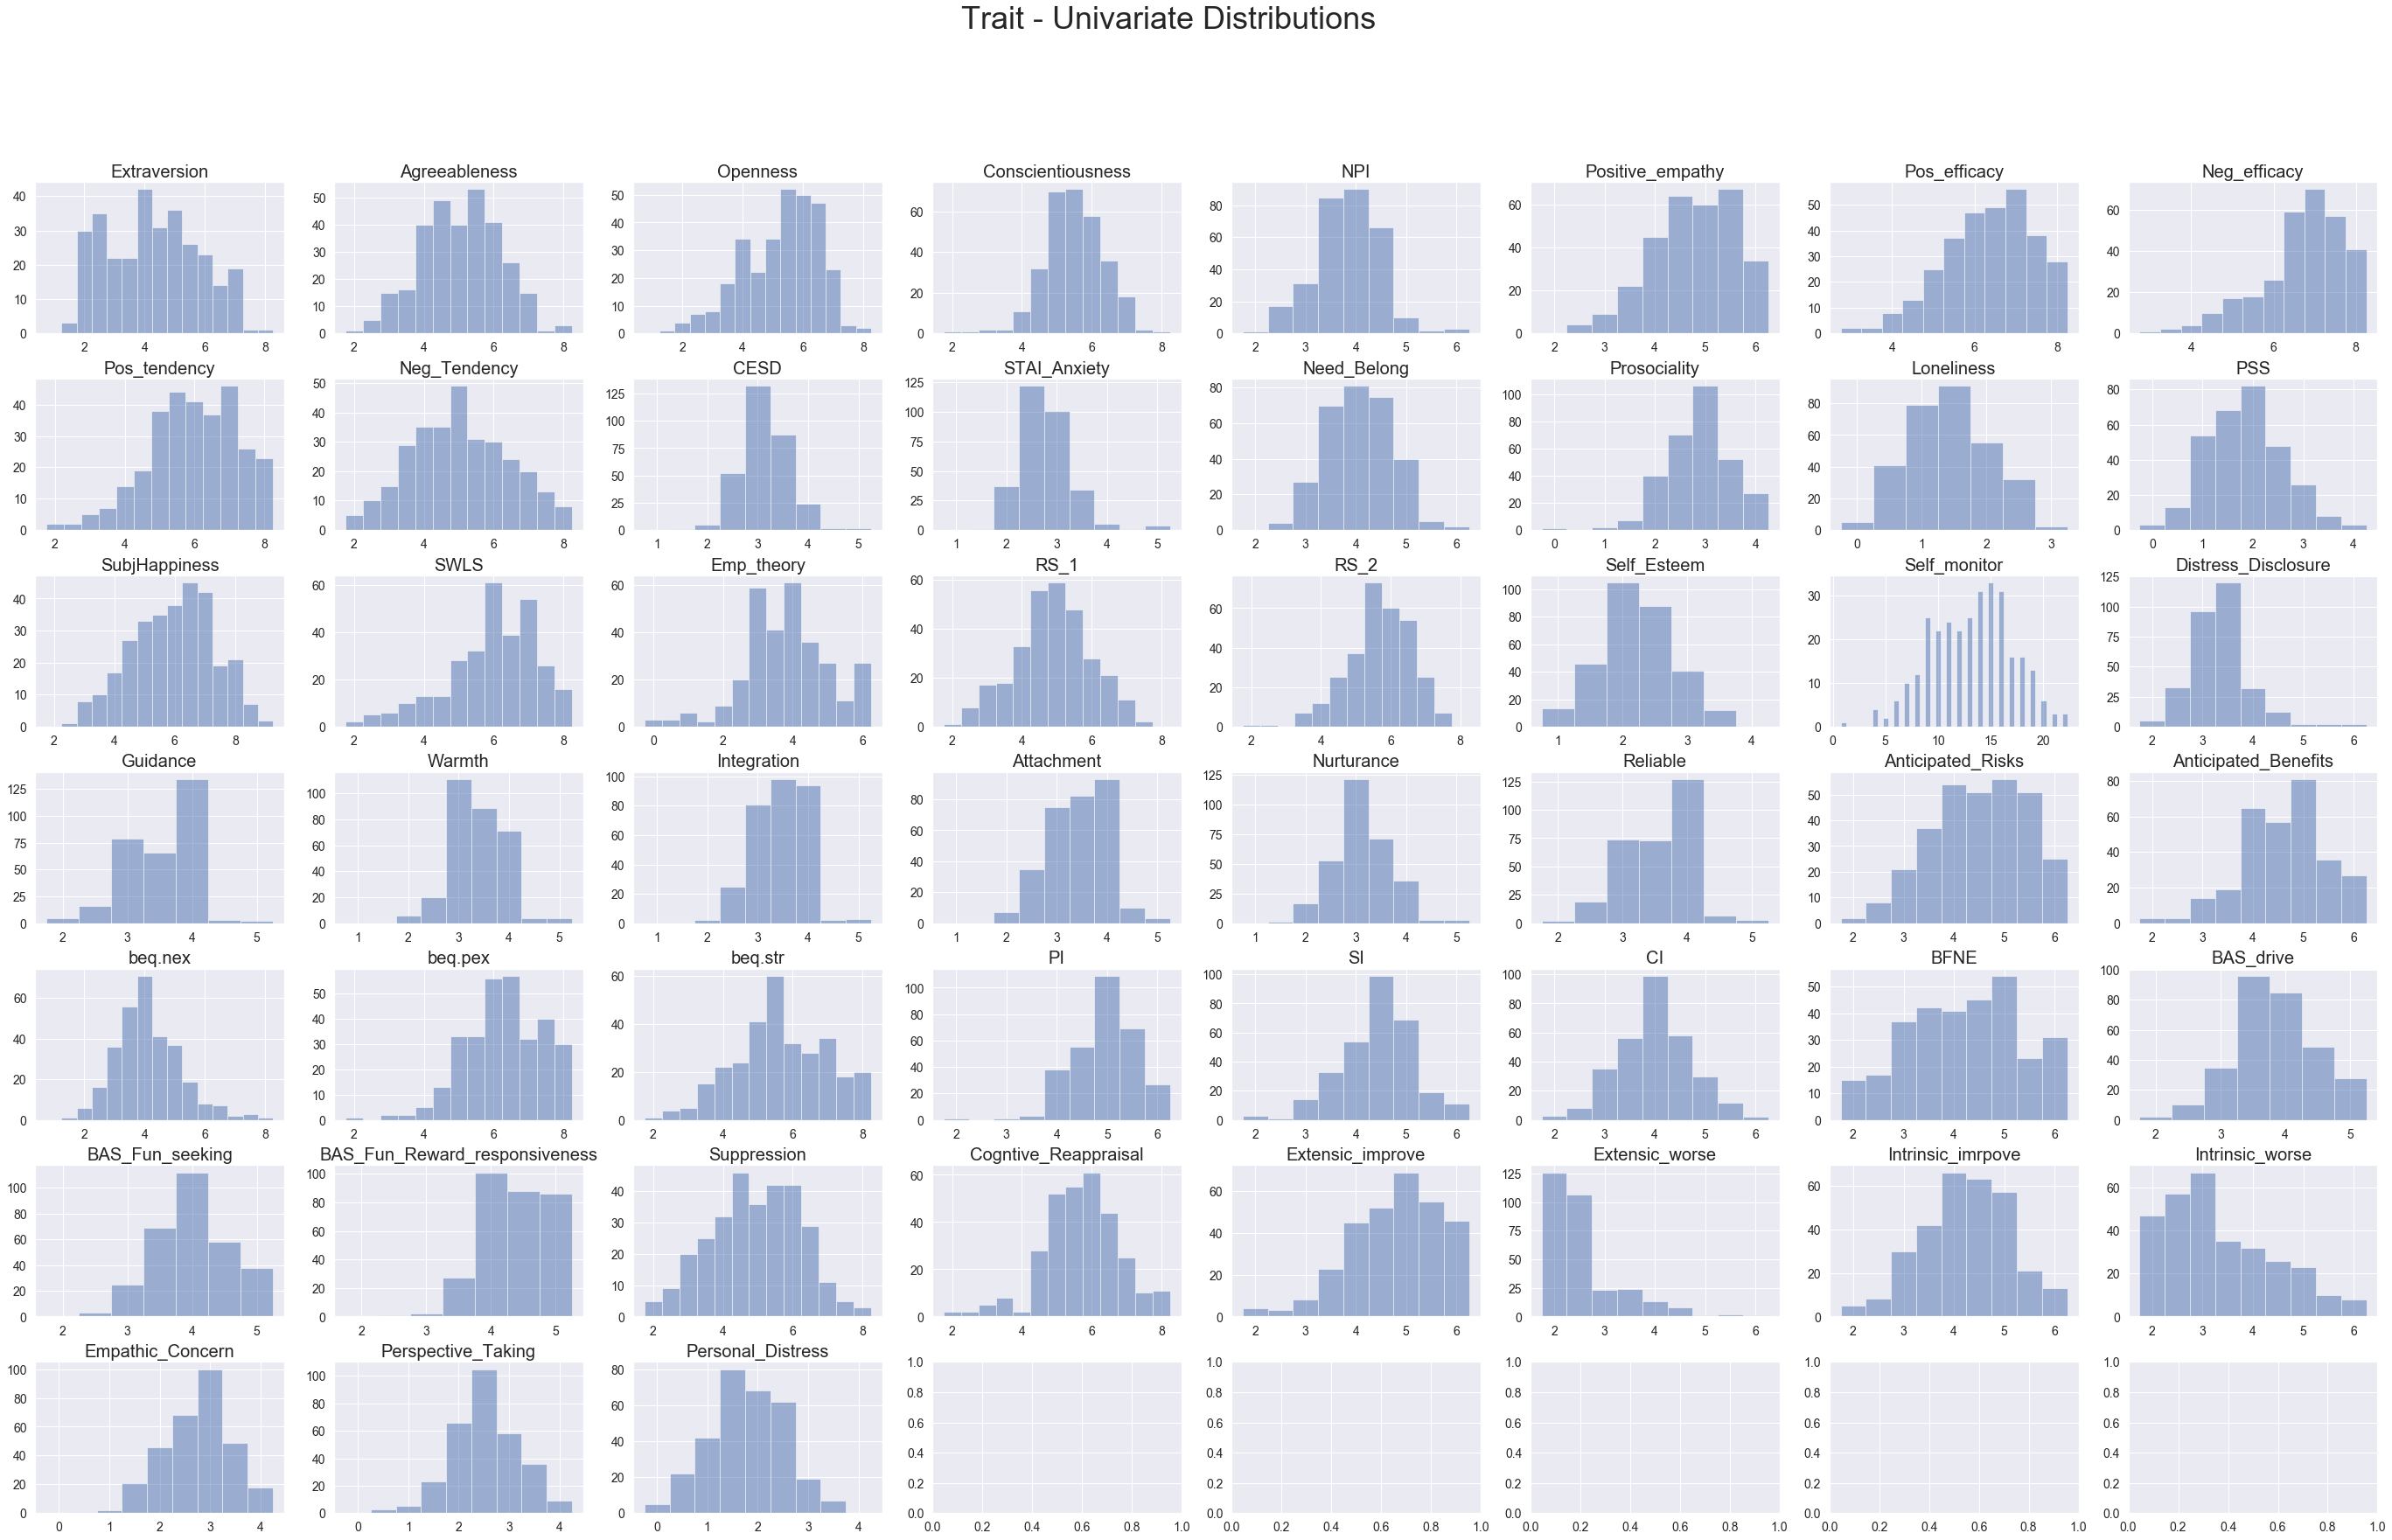

In [18]:
N = len(scores.columns)
ncol = int(np.ceil(np.sqrt(N)))
nrow = int(np.ceil((N - 1) / ncol))
print(f"Creating grid of plots, {nrow} x {ncol}")

fig, axes = plt.subplots(nrow, ncol)
axes = axes.flatten()
fig.set_size_inches(6 * ncol, 4 * nrow)
fig.suptitle(f"{DATASET_DISPLAYNAME} - Univariate Distributions", fontsize=36)
plt.subplots_adjust(hspace=.3)

for c, ax in zip(scores.columns, axes):
    na = scores[c].isnull().mean()
    ax.set_title(f"{c} (NA = {na:.2f}%)")
    ax.set_title(c)
    s = scores[c].dropna()
    lo = np.floor(s.min()) - .25
    hi = np.ceil(s.max()) + .25
    ax.hist(s, alpha=0.5, bins=np.arange(lo, hi+.01, .5))

saveplot(fig, 'univariate_distributions')

<div style="background-color: rgba(164,0,0,1);height: 20px"></div><!-- Thick deep-red bar -->

## PCA

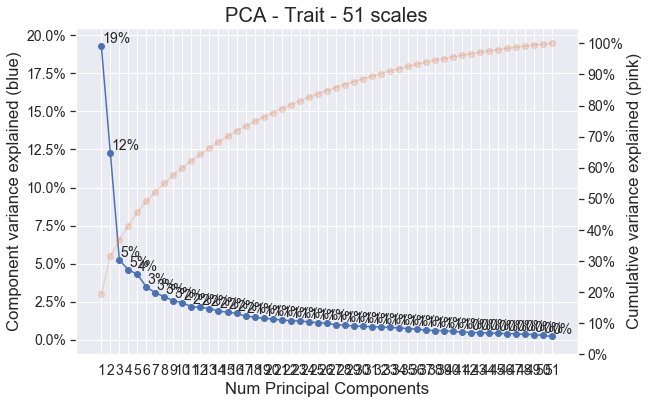

In [19]:
N = len(scores.columns)

pca = decomposition.PCA()
X = scores.dropna().values
X = preprocessing.scale(X)  # Scale/shift columns to N(0, 1)
pca.fit(X)

eigenvalues = pca.singular_values_
varex = pca.explained_variance_ratio_
varex_cum = np.array(varex).cumsum()
n_eigen = list(range(1, len(eigenvalues) + 1))

fig, ax = plt.subplots(1)
ax.set_title(f'PCA - {DATASET_DISPLAYNAME} - {N} scales')

ax.plot(n_eigen, varex)
ax.scatter(n_eigen, varex)
ax.set_xticks(n_eigen)

for i, val in enumerate(varex):
    ax.text(i+1.1, val, '%.0f%%' % (val*100),
            horizontalalignment='left',
            verticalalignment='bottom',
#             rotation=30
    )

ax.set_xlabel("Num Principal Components")
ax.set_ylabel("Component variance explained (blue)")
percentify_y(ax)

ax2 = ax.twinx()
ax2.plot(n_eigen, varex.cumsum(), color=sns.color_palette()[1], alpha=0.25)
ax2.scatter(n_eigen, varex.cumsum(), color=sns.color_palette()[1], alpha=0.25)
ax2.grid(False)
ax2.set_ylabel('Cumulative variance explained (pink)')
ax2.set_yticks(np.linspace(0, 1, 11))
percentify_y(ax2)

saveplot(fig, 'scree')

In [20]:
components = pd.DataFrame(pca.components_).T
components.columns=list(range(1, len(components.columns) + 1))
components.index = scores.columns

In [21]:
components[1].sort_values(ascending=False)

beq.pex                          0.215422
Guidance                         0.207426
Reliable                         0.206669
Integration                      0.201267
Intrinsic_imrpove                0.200762
Pos_efficacy                     0.198424
Neg_efficacy                     0.196938
Warmth                           0.195275
SubjHappiness                    0.193633
Positive_empathy                 0.190649
Anticipated_Benefits             0.190109
Attachment                       0.187278
SWLS                             0.168474
Prosociality                     0.166766
Pos_tendency                     0.166752
RS_2                             0.163992
Cogntive_Reappraisal             0.162936
Neg_Tendency                     0.160988
BAS_Fun_Reward_responsiveness    0.157975
Extensic_improve                 0.157741
BAS_Fun_seeking                  0.133031
Empathic_Concern                 0.131864
Nurturance                       0.126193
Perspective_Taking               0

In [22]:
components[2].sort_values(ascending=False)

BFNE                             0.301349
Need_Belong                      0.276638
Intrinsic_worse                  0.252889
Self_Esteem                      0.245537
PSS                              0.244387
beq.str                          0.236895
CESD                             0.213491
SI                               0.212081
Personal_Distress                0.201819
STAI_Anxiety                     0.199297
RS_1                             0.183539
Loneliness                       0.181588
beq.nex                          0.180066
Neg_efficacy                     0.149709
Pos_tendency                     0.139364
beq.pex                          0.137776
Distress_Disclosure              0.130488
Neg_Tendency                     0.130124
Empathic_Concern                 0.128325
PI                               0.127748
Anticipated_Risks                0.121917
Positive_empathy                 0.118339
Extensic_worse                   0.114809
Pos_efficacy                     0

In [23]:
components.loc['variance_explained', :] = varex
if WRITE_RESULTS:
    filename = os.path.join(RESULTS_DIR, DATASET + "_components.csv")
    print("Saving PCA weights to", filename)
    components.to_csv(filename)
else:
    print("To write the results of this analysis (plots, etc), "
          "set WRITE_RESULTS=True in the configuration block.")

Saving PCA weights to data/results/trait_components.csv
